In this notebook we clean the weather data collected from the [Climate Database Online](https://www.ncei.noaa.gov/cdo-web/search) compiled by NOAA. 

These datasets contain:
- Facility ID [STATION]: The station ID of the weather monitoring facility.
- Facility Name [NAME]: The name and state of the weather monitoring facility.
- Date [DATE]: The year and month of the measurement in YYYY-MM format.
- Rain [PRCP]: The amount of rain in inches measured at the facility.
- Snow Total [SNOW]: The aamount of snow in inches measured by the facility.

This notebook expects data to be stored in a directory `SharedData` at the root of the git repo. This directory should have the same structure as the `Data` folder stored on the project Google Drive.

In [71]:
# Import packages
import os
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
# Import the data
df1 = pd.read_csv(os.path.join("..", "..", "SharedData", "Weather (1990-2019)", "AL-GA,OK,OR.csv"))
df2 = pd.read_csv(os.path.join("..", "..", "SharedData", "Weather (1990-2019)", "HI-MN.csv"))
df3 = pd.read_csv(os.path.join("..", "..", "SharedData", "Weather (1990-2019)", "MS-OH.csv"))
df4 = pd.read_csv(os.path.join("..", "..", "SharedData", "Weather (1990-2019)", "PA-WY.csv"))
df = pd.concat([df1, df2, df3, df4])
df.sample(5)

,STATION,NAME,DATE,PRCP,SNOW,TAVG
2351,USW00014755,"MOUNT WASHINGTON, NH US",2006-03,3.35,22.3,11.4
2456,USW00014755,"MOUNT WASHINGTON, NH US",2014-12,9.26,58.8,16.7
4211,USW00094702,"IGOR I SIKORSKY MEMORIAL AIRPORT, CT US",2000-10,0.43,0.0,53.9
3641,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",2003-01,1.82,4.3,24.1
4221,USW00024089,"CASPER NATRONA CO AIRPORT, WY US",2011-10,1.44,1.0,48.5


In [73]:
# Extract state from facility name
df["state"] = df.NAME.str[-5:-3]
df.sample(5)

,STATION,NAME,DATE,PRCP,SNOW,TAVG,state
1136,USW00023050,"ALBUQUERQUE INTERNATIONAL AIRPORT, NM US",1994-12,0.62,0.5,40.8,NM
1130,USC00516128,"MANOA LYON ARBO 785.2, HI US",2002-12,5.32,0.0,72.3,HI
1926,USW00014742,"BURLINGTON INTERNATIONAL AIRPORT, VT US",2000-07,3.16,0.0,67.4,VT
3153,USW00012916,"NEW ORLEANS AIRPORT, LA US",1992-05,0.95,0.0,72.8,LA
2718,USW00014942,"OMAHA EPPLEY AIRFIELD, NE US",2007-03,4.15,7.9,46.3,NE


In [74]:
# Rename columns to be more consistent
df = df.rename(columns={"DATE":"date", "PRCP":"prcp", "SNOW":"snow", "TAVG":"tavg"})
df.sample(5)

,STATION,NAME,date,prcp,snow,tavg,state
3582,USW00013994,"ST LOUIS LAMBERT INTERNATIONAL AIRPORT, MO US",2019-03,5.63,2.4,42.6,MO
2781,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",2011-10,3.71,0.3,57.7,PA
2109,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",2016-01,1.13,5.4,28.5,OH
793,USW00014916,"GRAND FORKS INTERNATIONAL AIRPORT, ND US",1996-02,0.79,13.3,9.9,ND
3052,USW00014839,"MILWAUKEE MITCHELL AIRPORT, WI US",2004-05,8.17,0.0,54.7,WI


In [75]:
# Now sort the values by state and date
df = df.sort_values(["state", "date"])
# When there are no snow measurements, assume no snow
df.snow = df.snow.fillna(0)
# Do the same for rain
df.prcp = df.prcp.fillna(0)
# It's not reasonable to do this for temperature, 
# so interpolate over these values instead
# This simple approach MAY not be sufficient. May need to check:
#  (a) that linear interpolation is sufficient
#  (b) that this doesn't need to be done on a state-by-state basis
#      in order to prevent one state from affecting another's empty value
df.tavg = df.tavg.interpolate(method="linear")

In [76]:
# And now verify there are no other NA values
df.isna().sum()

STATION    0
NAME       0
date       0
prcp       0
snow       0
tavg       0
state      0
dtype: int64

In [77]:
# Write out a new CSV file, sorted by state and date
features = ["state", "date", "prcp", "snow", "tavg"]
new_df = df[features].sort_values(["state", "date"])
new_df.to_csv("monthly-weather-1990-2019-final.csv", index=False)

In [78]:
# Verify no duplicate dates
abbreviations = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]
count = 0
for i in abbreviations:
    if len(new_df[new_df.state==i].date.unique()) != len(new_df[new_df.state==i]):
        print(i)
        count += 1
if not count:
    print("All dates are unique for each state!")

All dates are unique for each state!


Finally, make some plots of these features to make sure they make sense. This should also expose any non-numeric values that may have snuck past.

Text(0, 0.5, 'Precipitation (in)')

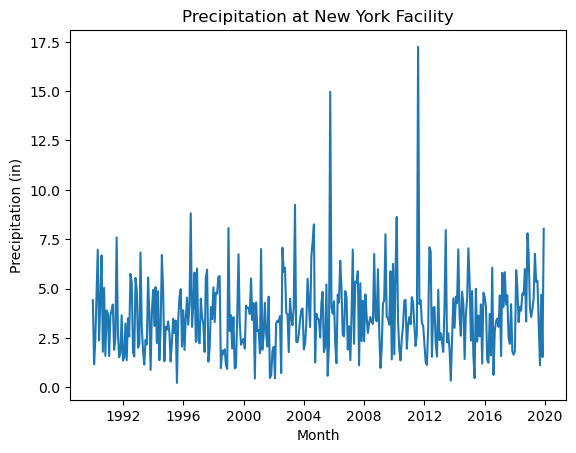

In [79]:
plt.plot(new_df[new_df.state=="NY"].date.astype("date64[pyarrow]"), new_df[new_df.state=="NY"].prcp)
plt.title("Precipitation at New York Facility")
plt.xlabel("Month")
plt.ylabel("Precipitation (in)")

Text(0, 0.5, 'Snow (in)')

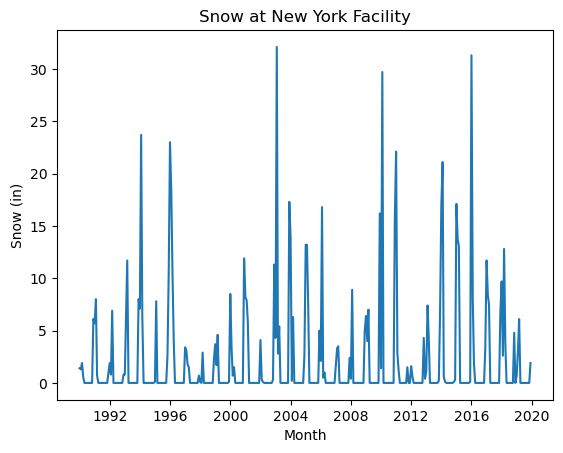

In [80]:
plt.plot(new_df[new_df.state=="NY"].date.astype("date64[pyarrow]"), new_df[new_df.state=="NY"].snow)
plt.title("Snow at New York Facility")
plt.xlabel("Month")
plt.ylabel("Snow (in)")

Text(0, 0.5, 'Temperature (degrees Fahrenheit)')

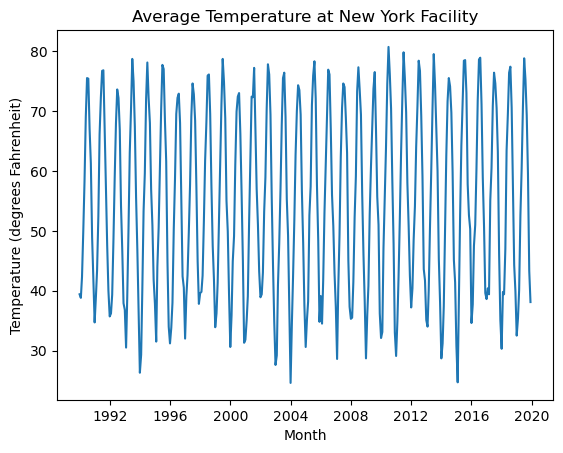

In [81]:
plt.plot(new_df[new_df.state=="NY"].date.astype("date64[pyarrow]"), new_df[new_df.state=="NY"].tavg)
plt.title("Average Temperature at New York Facility")
plt.xlabel("Month")
plt.ylabel("Temperature (degrees Fahrenheit)")